In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U sentence-transformers > /dev/null

In [ ]:
!pip install bertopic > /dev/null
!pip install bertopic[visualization] > /dev/null

In [ ]:
!ls 'drive/MyDrive/Colab Notebooks/nlp/clustering kpa'

1_KPA_clustering.ipynb		     6_legal_clustering_topic_bert.ipynb
2_KPA_clustering_fine-tunning.ipynb  7_explore_final.ipynb
3_legal_clustering.ipynb	     8_pegasus_sum_berttopic.ipynb
4_legal_barh_clustering.ipynb	     data
5_legal_clustering_legal_bert.ipynb


In [ ]:
import json
import sklearn
import sklearn.model_selection
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

In [ ]:
random_state = 321

# Prepare data

In [ ]:
legal_data = pd.read_pickle('drive/MyDrive/Colab Notebooks/nlp/clustering kpa/data/echr_arguments_clustered_legal_bert.pkl')

In [ ]:
legal_data = legal_data.drop(columns=['cluster_id'])
legal_data.head()

,id,argument,embedding,tsne_30_x,tsne_30_y,argument_id
0,1,The Commission notes that the applicant was de...,"[-0.54420865, 0.10708204, -0.33214608, -0.1024...",-20.717447,-56.532124,1
1,2,He was released after the Court of Appeal revi...,"[-0.3446362, -0.1886111, 0.15328027, -0.357862...",-23.226044,-55.705254,2
2,3,Article 5 para. 1 (Art. 5-1) of the Conventio...,"[-0.595209, -0.112412356, 0.103474185, 0.03031...",40.096104,44.235756,3
3,4,The Commission finds that the applicant was de...,"[-0.7030391, -0.21792084, 0.17640072, -0.08939...",39.492611,41.208103,4
4,5,The Commission also finds no evidence in the c...,"[-0.6256406, -0.08068405, -0.09766886, -0.1367...",45.119465,31.979721,5


In [ ]:
legal_data.shape

(1951, 6)

In [ ]:
legal_with_files_data = pd.read_csv('drive/MyDrive/Colab Notebooks/nlp/clustering kpa/data/echr_arguments_with_files.csv')
legal_with_files_data.head()

,id,name,argument
0,1,00.txt,The Commission notes that the applicant was de...
1,2,00.txt,He was released after the Court of Appeal revi...
2,3,00.txt,Article 5 para. 1 (Art. 5-1) of the Conventio...
3,4,00.txt,The Commission finds that the applicant was de...
4,5,00.txt,The Commission also finds no evidence in the c...


In [ ]:
merged_df = pd.merge(legal_data,legal_with_files_data,on='id',how='inner')
print(merged_df.shape)
merged_df.head()

(1951, 8)


,id,argument_x,embedding,tsne_30_x,tsne_30_y,argument_id,name,argument_y
0,1,The Commission notes that the applicant was de...,"[-0.54420865, 0.10708204, -0.33214608, -0.1024...",-20.717447,-56.532124,1,00.txt,The Commission notes that the applicant was de...
1,2,He was released after the Court of Appeal revi...,"[-0.3446362, -0.1886111, 0.15328027, -0.357862...",-23.226044,-55.705254,2,00.txt,He was released after the Court of Appeal revi...
2,3,Article 5 para. 1 (Art. 5-1) of the Conventio...,"[-0.595209, -0.112412356, 0.103474185, 0.03031...",40.096104,44.235756,3,00.txt,Article 5 para. 1 (Art. 5-1) of the Conventio...
3,4,The Commission finds that the applicant was de...,"[-0.7030391, -0.21792084, 0.17640072, -0.08939...",39.492611,41.208103,4,00.txt,The Commission finds that the applicant was de...
4,5,The Commission also finds no evidence in the c...,"[-0.6256406, -0.08068405, -0.09766886, -0.1367...",45.119465,31.979721,5,00.txt,The Commission also finds no evidence in the c...


In [ ]:
merged_df[merged_df['argument_x']!=merged_df['argument_y']]

,id,argument_x,embedding,tsne_30_x,tsne_30_y,argument_id,name,argument_y


In [ ]:
df = merged_df.drop(columns=['argument_y']).rename(columns={'argument_x':'argument'})
print(df.shape)
df.head()

(1951, 7)


,id,argument,embedding,tsne_30_x,tsne_30_y,argument_id,name
0,1,The Commission notes that the applicant was de...,"[-0.54420865, 0.10708204, -0.33214608, -0.1024...",-20.717447,-56.532124,1,00.txt
1,2,He was released after the Court of Appeal revi...,"[-0.3446362, -0.1886111, 0.15328027, -0.357862...",-23.226044,-55.705254,2,00.txt
2,3,Article 5 para. 1 (Art. 5-1) of the Conventio...,"[-0.595209, -0.112412356, 0.103474185, 0.03031...",40.096104,44.235756,3,00.txt
3,4,The Commission finds that the applicant was de...,"[-0.7030391, -0.21792084, 0.17640072, -0.08939...",39.492611,41.208103,4,00.txt
4,5,The Commission also finds no evidence in the c...,"[-0.6256406, -0.08068405, -0.09766886, -0.1367...",45.119465,31.979721,5,00.txt


# Groupby

In [ ]:
df_grouped_name = df.groupby('name')
groups_num = len(df_grouped_name)
groups_num

42

In [ ]:
groups_keys = df_grouped_name.groups.keys()
groups_keys

dict_keys(['00.txt', '01.txt', '02.txt', '03.txt', '04.txt', '05.txt', '06.txt', '07.txt', '08.txt', '09.txt', '10.txt', '11.txt', '12.txt', '13.txt', '14.txt', '15.txt', '16.txt', '17.txt', '18.txt', '19.txt', '20.txt', '21.txt', '22.txt', '23.txt', '24.txt', '25.txt', '26.txt', '27.txt', '28.txt', '29.txt', '30.txt', '31.txt', '32.txt', '33.txt', '34.txt', '35.txt', '37.txt', '38.txt', '39.txt', '40.txt', '41.txt', '42.txt'])

# BERTopic

In [ ]:
from bertopic import BERTopic

In [ ]:
# models_grouped = []
# topics_grouped = []
# probabilities_grouped = []
# for i in groups_keys:
#   print(i)
#   model = BERTopic(nr_topics="auto")
#   topics, probabilities = model.fit_transform(df_grouped_name.get_group(i)['argument'].tolist(),np.stack(df_grouped_name.get_group(i)['embedding']))

#   models_grouped.append(model)
#   topics_grouped.append(topics)
#   probabilities_grouped.append(probabilities_grouped)

In [ ]:
df_grouped_name.count()['id']

name
00.txt     51
01.txt     46
02.txt     17
03.txt     15
04.txt     14
05.txt     25
06.txt     18
07.txt     48
08.txt     88
09.txt     21
10.txt     32
11.txt    105
12.txt     33
13.txt     19
14.txt     60
15.txt     54
16.txt     32
17.txt     99
18.txt     54
19.txt    107
20.txt     53
21.txt     41
22.txt    147
23.txt     38
24.txt     49
25.txt     43
26.txt     45
27.txt     97
28.txt     84
29.txt     79
30.txt     23
31.txt     15
32.txt     17
33.txt     22
34.txt    105
35.txt     11
37.txt     67
38.txt     32
39.txt     15
40.txt      8
41.txt      8
42.txt     14
Name: id, dtype: int64

In [ ]:
model = BERTopic()
group_id = '09.txt'
topics, probabilities = model.fit_transform(df_grouped_name.get_group(group_id)['argument'].tolist(),np.stack(df_grouped_name.get_group(group_id)['embedding']))
np.array(topics)

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1])

In [ ]:
model = BERTopic()
group_id = '10.txt'
topics, probabilities = model.fit_transform(df_grouped_name.get_group(group_id)['argument'].tolist(),np.stack(df_grouped_name.get_group(group_id)['embedding']))
np.array(topics)

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [ ]:
model = BERTopic()
group_id = '11.txt'
topics, probabilities = model.fit_transform(df_grouped_name.get_group(group_id)['argument'].tolist(),np.stack(df_grouped_name.get_group(group_id)['embedding']))
np.array(topics)

array([-1,  0,  0,  0,  0,  0,  1,  0,  1, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  1,  1,  1,
        1,  0,  1,  1,  1,  1,  1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  0,  0,  1,  1,  0,  1,  1, -1,  0,  0,  0,  0,  0,  0,  0,  1,
        0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  0,  1,  0,  0,  1,  0,  1,
        1,  1, -1,  0,  1,  1,  1,  0,  0,  0, -1, -1,  1,  1,  1,  1,  1,
        1,  1, -1])

In [ ]:
group_id_1 = '09.txt'
group_id_2 = '10.txt'
df_to_try = pd.concat([df_grouped_name.get_group(group_id_1),df_grouped_name.get_group(group_id_2)])
df_to_try.shape

(53, 7)

In [ ]:
model = BERTopic()

topics, probabilities = model.fit_transform(df_to_try['argument'].tolist(),np.stack(df_to_try['embedding']))
np.array(topics)

array([ 1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1,  0, -1,  0,  0,  0, -1, -1,  1,  1,  1, -1,  1, -1,
        1,  1,  1,  0, -1,  0,  0,  1,  0,  0,  0, -1,  0,  0,  0,  0,  0,
        0, -1])

In [ ]:
model = BERTopic()
group_id = '24.txt'
topics, probabilities = model.fit_transform(df_grouped_name.get_group(group_id)['argument'].tolist(),np.stack(df_grouped_name.get_group(group_id)['embedding']))
np.array(topics)

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [ ]:
model = BERTopic()
group_id = '20.txt'
topics, probabilities = model.fit_transform(df_grouped_name.get_group(group_id)['argument'].tolist(),np.stack(df_grouped_name.get_group(group_id)['embedding']))
np.array(topics)

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1])

In [ ]:
# model = BERTopic()
# group_id = '40.txt'
# topics, probabilities = model.fit_transform(df_grouped_name.get_group(group_id)['argument'].tolist(),np.stack(df_grouped_name.get_group(group_id)['embedding']))
# np.array(topics)

# Hierarchical clustering

In [ ]:
def agglomerative_clustering(corpus, n_clusters, distance_threshold):
    corpus_embeddings = corpus['embedding'].tolist()
    # Normalize the embeddings to unit length
    corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters, distance_threshold=distance_threshold)#affinity='cosine', linkage='average', distance_threshold=0.4)
    clustering_model.fit_predict(corpus_embeddings)
    cluster_assignment = clustering_model.labels_
    clustered_sentences = {}
    clustered_embedding = {}
    for sentence_id, cluster_id in enumerate(cluster_assignment):
        if cluster_id not in clustered_sentences:
            clustered_sentences[cluster_id] = []
        clustered_sentences[cluster_id].append(corpus['id'][sentence_id])
    
    df = pd.DataFrame({"cluster_id": clustered_sentences.keys(), "argument_id": clustered_sentences.values()})
    return df

In [ ]:
def run_clustering(df, n_clusters, distance_threshold, figsize=(15, 15)):
  clustered_df = agglomerative_clustering(df, n_clusters=n_clusters,distance_threshold=distance_threshold)
  merged_df = pd.merge(df,clustered_df.explode('argument_id'),how='left', left_on=['id'], right_on = ['argument_id'])
  plt.figure(figsize=figsize)
  for i,group in merged_df.groupby('cluster_id'):
    plt.scatter(group['tsne_30_x'], group['tsne_30_y'], alpha=.5, label = i)
  plt.legend(loc='lower right')
  return merged_df

In [ ]:
# # %%time
# group_id = '20.txt'
# print(df_grouped_name.get_group(group_id).head())
# clustered_df = run_clustering(df_grouped_name.get_group(group_id), n_clusters=None,distance_threshold=2.0,)
# print(clustered_df.shape)
# clustered_df.head()

# BERTopic + oversampling

In [ ]:
models_grouped = []
topics_grouped = []
probabilities_grouped = []
oversampled_tag = {}
for i in groups_keys:
  curr_df = df_grouped_name.get_group(i)
  model = BERTopic(nr_topics="auto")
  oversampled_tag[i] = False
  while True:
    try:
      print(f"{i} size of {curr_df.shape}")
      topics, probabilities = model.fit_transform(curr_df['argument'].tolist(),np.stack(curr_df['embedding']))
      break;
    except:
      print('Oversample')
      oversampled_tag[i] = True
      curr_df = pd.concat([curr_df,curr_df])

  models_grouped.append(model)
  topics_grouped.append(topics)
  probabilities_grouped.append(probabilities_grouped)

00.txt size of (51, 7)
01.txt size of (46, 7)
Oversample
01.txt size of (92, 7)
02.txt size of (17, 7)
Oversample
02.txt size of (34, 7)
Oversample
02.txt size of (68, 7)
03.txt size of (15, 7)
Oversample
03.txt size of (30, 7)
04.txt size of (14, 7)
Oversample
04.txt size of (28, 7)
05.txt size of (25, 7)
Oversample
05.txt size of (50, 7)
06.txt size of (18, 7)
Oversample
06.txt size of (36, 7)
07.txt size of (48, 7)
Oversample
07.txt size of (96, 7)
08.txt size of (88, 7)
09.txt size of (21, 7)
Oversample
09.txt size of (42, 7)
10.txt size of (32, 7)
Oversample
10.txt size of (64, 7)
11.txt size of (105, 7)
12.txt size of (33, 7)
Oversample
12.txt size of (66, 7)
13.txt size of (19, 7)
Oversample
13.txt size of (38, 7)
Oversample
13.txt size of (76, 7)
14.txt size of (60, 7)
15.txt size of (54, 7)
Oversample
15.txt size of (108, 7)
16.txt size of (32, 7)
Oversample
16.txt size of (64, 7)
17.txt size of (99, 7)
18.txt size of (54, 7)
Oversample
18.txt size of (108, 7)
19.txt size of (

In [ ]:
models_grouped

In [ ]:
res_clustered_df = None

for i,key in enumerate(groups_keys):
  curr_df = df_grouped_name.get_group(key)
  print(key)
  print(f"Before oversampling {len(curr_df)}")
  print(f"After oversampling {len(topics_grouped[i])}")
  curr_df['cluster_id'] = topics_grouped[i][0:len(curr_df)]
  if res_clustered_df is None:
    print('Create DF')
    res_clustered_df = curr_df.copy()
  else:
    print('Append to the existing DF')
    res_clustered_df = pd.concat([res_clustered_df,curr_df.copy()])
  # print(curr_df.head())

00.txt
Before oversampling 51
After oversampling 51
Create DF
01.txt
Before oversampling 46
After oversampling 92
Append to the existing DF
02.txt
Before oversampling 17
After oversampling 68
Append to the existing DF
03.txt
Before oversampling 15
After oversampling 30
Append to the existing DF
04.txt
Before oversampling 14
After oversampling 28
Append to the existing DF
05.txt
Before oversampling 25
After oversampling 50
Append to the existing DF
06.txt
Before oversampling 18
After oversampling 36
Append to the existing DF
07.txt
Before oversampling 48
After oversampling 96
Append to the existing DF
08.txt
Before oversampling 88
After oversampling 88
Append to the existing DF
09.txt
Before oversampling 21
After oversampling 42
Append to the existing DF
10.txt
Before oversampling 32
After oversampling 64
Append to the existing DF
11.txt
Before oversampling 105
After oversampling 105
Append to the existing DF
12.txt
Before oversampling 33
After oversampling 66
Append to the existing DF


In [ ]:
res_clustered_df.shape

(1951, 8)

In [ ]:
groups_keys

dict_keys(['00.txt', '01.txt', '02.txt', '03.txt', '04.txt', '05.txt', '06.txt', '07.txt', '08.txt', '09.txt', '10.txt', '11.txt', '12.txt', '13.txt', '14.txt', '15.txt', '16.txt', '17.txt', '18.txt', '19.txt', '20.txt', '21.txt', '22.txt', '23.txt', '24.txt', '25.txt', '26.txt', '27.txt', '28.txt', '29.txt', '30.txt', '31.txt', '32.txt', '33.txt', '34.txt', '35.txt', '37.txt', '38.txt', '39.txt', '40.txt', '41.txt', '42.txt'])

00.txt
Is oversampled False
Shape (51, 8)
Cluster id -1 size of (16, 8)
Cluster id 0 size of (18, 8)
Cluster id 1 size of (17, 8)


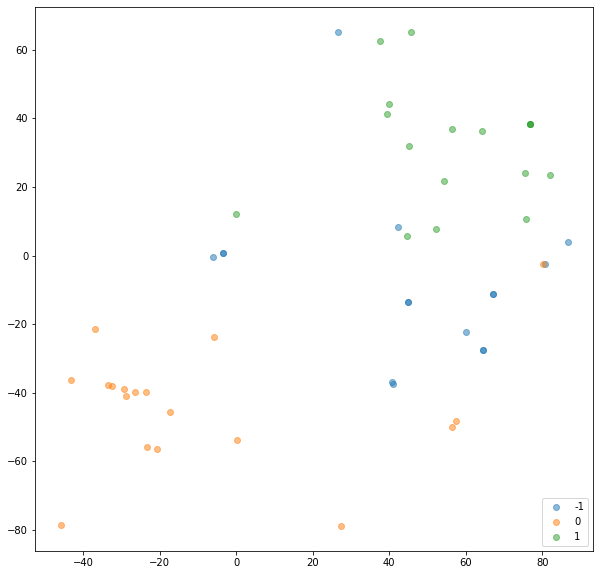

In [ ]:
res_to_show = 0
curr_df = res_clustered_df.groupby('name').get_group(list(groups_keys)[res_to_show])

print(list(groups_keys)[res_to_show])
print(f"Is oversampled {oversampled_tag[list(groups_keys)[res_to_show]]}")
print(f"Shape {curr_df.shape}")

plt.figure(figsize=(10,10))
for i,group in curr_df.groupby('cluster_id'):
  print(f'Cluster id {i} size of {group.shape}')
  plt.scatter(group['tsne_30_x'], group['tsne_30_y'], alpha=.5, label = i)
plt.legend(loc='lower right')

In [ ]:
res_clustered_df.head()

,id,argument,embedding,tsne_30_x,tsne_30_y,argument_id,name,cluster_id
0,1,The Commission notes that the applicant was de...,"[-0.54420865, 0.10708204, -0.33214608, -0.1024...",-20.717447,-56.532124,1,00.txt,0
1,2,He was released after the Court of Appeal revi...,"[-0.3446362, -0.1886111, 0.15328027, -0.357862...",-23.226044,-55.705254,2,00.txt,0
2,3,Article 5 para. 1 (Art. 5-1) of the Conventio...,"[-0.595209, -0.112412356, 0.103474185, 0.03031...",40.096104,44.235756,3,00.txt,1
3,4,The Commission finds that the applicant was de...,"[-0.7030391, -0.21792084, 0.17640072, -0.08939...",39.492611,41.208103,4,00.txt,1
4,5,The Commission also finds no evidence in the c...,"[-0.6256406, -0.08068405, -0.09766886, -0.1367...",45.119465,31.979721,5,00.txt,1


In [ ]:
res_clustered_df.to_csv('drive/MyDrive/Colab Notebooks/nlp/clustering kpa/data/echr_arguments_clustered_legal_bert_berttopic_per_file.csv')
res_clustered_df.to_pickle('drive/MyDrive/Colab Notebooks/nlp/clustering kpa/data/echr_arguments_clustered_legal_bert_berttopic_per_file.pkl')

# Pegasus

In [ ]:
!pip install transformers -q > /dev/null
!pip install sentencepiece -q > /dev/null
!pip install rouge_score -q > /dev/null

In [ ]:
import nltk
import torch
from collections import OrderedDict
from transformers import set_seed, PegasusTokenizer, PegasusForConditionalGeneration

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = PegasusTokenizer.from_pretrained('google/pegasus-xsum')
model = PegasusForConditionalGeneration.from_pretrained('google/pegasus-xsum')

In [ ]:
print(device)
model.to(device)
print('')

cuda



In [ ]:
def summarize(args:list,delim:str=". ")->str:
  paragraph = delim.join(args)
  tokenized_paragraph = tokenizer(paragraph, return_tensors="pt").to(device)
  tokenized_output = model.generate(**tokenized_paragraph)
  detokenized_output = tokenizer.batch_decode(tokenized_output, skip_special_tokens=True)
  return detokenized_output[0]

def get_topic(args:list, use_unique=False)->str:
  unique_args = args if not use_unique else list(OrderedDict.fromkeys(args))
  max_count = 4
  summaries = []
  args_count = 0
  while(True):
    args_count = len(unique_args)
    print(args_count)
    if(args_count>max_count):
      summaries = []
      buckets_count = int(np.ceil(args_count/max_count))
      for i in range(buckets_count):
        if (i+1)*max_count>args_count:
          summaries.append(summarize(unique_args[i*max_count:args_count]))
        else:
          summaries.append(summarize(unique_args[i*max_count:(i+1)*max_count]))
      unique_args = summaries if not use_unique else list(OrderedDict.fromkeys(summaries))
    else:
      return summarize(unique_args)

In [ ]:
res_clustered_df.head()

,id,argument,embedding,tsne_30_x,tsne_30_y,argument_id,name,cluster_id
0,1,The Commission notes that the applicant was de...,"[-0.54420865, 0.10708204, -0.33214608, -0.1024...",-20.717447,-56.532124,1,00.txt,0
1,2,He was released after the Court of Appeal revi...,"[-0.3446362, -0.1886111, 0.15328027, -0.357862...",-23.226044,-55.705254,2,00.txt,0
2,3,Article 5 para. 1 (Art. 5-1) of the Conventio...,"[-0.595209, -0.112412356, 0.103474185, 0.03031...",40.096104,44.235756,3,00.txt,1
3,4,The Commission finds that the applicant was de...,"[-0.7030391, -0.21792084, 0.17640072, -0.08939...",39.492611,41.208103,4,00.txt,1
4,5,The Commission also finds no evidence in the c...,"[-0.6256406, -0.08068405, -0.09766886, -0.1367...",45.119465,31.979721,5,00.txt,1


In [ ]:
%%time

topics = []



for i, group_name in res_clustered_df.groupby('name'):
  for j, group_cluster_name in group_name.groupby('cluster_id'):
    print(f"Text {i} ClusterID {j} {group_cluster_name.shape}")
    result = get_topic(group_cluster_name['argument'].tolist())
    topics.append(result)
    print(result)

Text 00.txt ClusterID -1 (16, 8)
16
4
The European Court of Justice (ECJ) has upheld a decision of the Court of Cassation in which it held that the applicant had not raised his complaints during the proceedings before the Court of Cassation.
Text 00.txt ClusterID 0 (18, 8)
18
5
2
The European Court of Human Rights (ECHR) has ruled in favour of a Turkish-Armenian writer who was convicted of insulting the Turkish president and sentenced to three years in prison.
Text 00.txt ClusterID 1 (17, 8)
17
5
2
The European Court of Human Rights (ECHR) is the highest court of human rights in the European Union.
Text 01.txt ClusterID 0 (24, 8)
24
6
2
The European Court of Human Rights has ruled that the Turkish authorities did not breach the human rights of an applicant when they arrested him and took him into custody.
Text 01.txt ClusterID 1 (9, 8)
9
3
The Court of Appeal has upheld a decision by the High Court to dismiss an appeal by a man who claimed he was the victim of racial discrimination.
Te

In [ ]:
res_labeled_df = None

k=0

for i, group_name in res_clustered_df.groupby('name'):
  for j, group_cluster_name in group_name.groupby('cluster_id'):
    print(f"Text {i} ClusterID {j} {group_cluster_name.shape}")
    group_cluster_name['name'] =  i
    group_cluster_name['cluster_id'] = j
    group_cluster_name['kp'] = topics[k]
    k+=1
    if res_labeled_df is None:
      res_labeled_df = group_cluster_name.copy()
    else:
      res_labeled_df = pd.concat([res_labeled_df, group_cluster_name.copy()])

Text 00.txt ClusterID -1 (16, 8)
Text 00.txt ClusterID 0 (18, 8)
Text 00.txt ClusterID 1 (17, 8)
Text 01.txt ClusterID 0 (24, 8)
Text 01.txt ClusterID 1 (9, 8)
Text 01.txt ClusterID 2 (7, 8)
Text 01.txt ClusterID 3 (6, 8)
Text 02.txt ClusterID 0 (14, 8)
Text 02.txt ClusterID 1 (3, 8)
Text 03.txt ClusterID 0 (8, 8)
Text 03.txt ClusterID 1 (7, 8)
Text 04.txt ClusterID 0 (8, 8)
Text 04.txt ClusterID 1 (6, 8)
Text 05.txt ClusterID -1 (9, 8)
Text 05.txt ClusterID 0 (8, 8)
Text 05.txt ClusterID 1 (8, 8)
Text 06.txt ClusterID 0 (12, 8)
Text 06.txt ClusterID 1 (6, 8)
Text 07.txt ClusterID -1 (5, 8)
Text 07.txt ClusterID 0 (37, 8)
Text 07.txt ClusterID 1 (6, 8)
Text 08.txt ClusterID -1 (3, 8)
Text 08.txt ClusterID 0 (54, 8)
Text 08.txt ClusterID 1 (31, 8)
Text 09.txt ClusterID -1 (5, 8)
Text 09.txt ClusterID 0 (10, 8)
Text 09.txt ClusterID 1 (6, 8)
Text 10.txt ClusterID 0 (22, 8)
Text 10.txt ClusterID 1 (10, 8)
Text 11.txt ClusterID -1 (11, 8)
Text 11.txt ClusterID 0 (57, 8)
Text 11.txt Cluster

In [ ]:
print(res_labeled_df.shape)
res_labeled_df

(1951, 9)


,id,argument,embedding,tsne_30_x,tsne_30_y,argument_id,name,cluster_id,kp
6,7,The applicant was not detained on remand prior...,"[-0.36789796, 0.18494742, -0.0407059, -0.18608...",86.694954,3.884715,7,00.txt,-1,The European Court of Justice (ECJ) has upheld...
7,8,"However, again, the Commission finds no eviden...","[-0.445525, 0.27075595, -0.045888044, 0.098298...",60.149704,-22.158417,8,00.txt,-1,The European Court of Justice (ECJ) has upheld...
14,15,"For this condition to be fulfilled, it is no...","[0.031011797, 0.4394446, 0.08093596, -0.458023...",44.827148,-13.566013,15,00.txt,-1,The European Court of Justice (ECJ) has upheld...
15,16,The complaint made before the Commission must ...,"[-0.39087832, 0.16677605, -0.17844024, 0.22170...",67.164505,-11.211986,16,00.txt,-1,The European Court of Justice (ECJ) has upheld...
17,18,"In the present case, the Commission notes tha...","[-0.8164517, 0.32662082, -0.37881488, -0.14860...",64.620003,-27.645006,18,00.txt,-1,The European Court of Justice (ECJ) has upheld...
...,...,...,...,...,...,...,...,...,...
1250,1251,"In these circumstances, the Commission fin...","[-0.8001709, 0.35395452, 0.22154054, -0.256540...",66.489372,30.271854,1251,42.txt,1,The European Commission has held that a compla...
1251,1252,The applicant's submissions do not disclose an...,"[-0.46814257, 0.5735056, -0.0134364255, -0.604...",44.249180,-33.752033,1252,42.txt,1,The European Commission has held that a compla...
1240,1241,They further consider that she failed\r\nprope...,"[-0.18369436, 0.3833738, 0.100332074, -0.06312...",-2.536663,-36.686512,1241,42.txt,2,The judges of the Constitutional Court conside...
1248,1249,The\r\ncompetence of the Constitutional Court ...,"[-0.34228554, 0.36269462, 0.065987386, 0.07800...",13.097253,-33.572418,1249,42.txt,2,The judges of the Constitutional Court conside...


In [ ]:
res_labeled_df.drop(columns=['embedding']).to_csv('drive/MyDrive/Colab Notebooks/nlp/clustering kpa/data/echr_arguments_clustered_legal_bert_berttopic_per_file_labeled_pegasus.csv')
res_labeled_df.drop(columns=['embedding']).to_pickle('drive/MyDrive/Colab Notebooks/nlp/clustering kpa/data/echr_arguments_clustered_legal_bert_berttopic_per_file_labeled_pegasus.pkl')

# Run Pegasus for each sentence

In [ ]:
df.head()

,id,argument,embedding,tsne_30_x,tsne_30_y,argument_id,name
0,1,The Commission notes that the applicant was de...,"[-0.54420865, 0.10708204, -0.33214608, -0.1024...",-20.717447,-56.532124,1,00.txt
1,2,He was released after the Court of Appeal revi...,"[-0.3446362, -0.1886111, 0.15328027, -0.357862...",-23.226044,-55.705254,2,00.txt
2,3,Article 5 para. 1 (Art. 5-1) of the Conventio...,"[-0.595209, -0.112412356, 0.103474185, 0.03031...",40.096104,44.235756,3,00.txt
3,4,The Commission finds that the applicant was de...,"[-0.7030391, -0.21792084, 0.17640072, -0.08939...",39.492611,41.208103,4,00.txt
4,5,The Commission also finds no evidence in the c...,"[-0.6256406, -0.08068405, -0.09766886, -0.1367...",45.119465,31.979721,5,00.txt


In [ ]:
def summarize(paragraph:str)->str:
  tokenized_paragraph = tokenizer(paragraph, return_tensors="pt").to(device)
  tokenized_output = model.generate(**tokenized_paragraph)
  detokenized_output = tokenizer.batch_decode(tokenized_output, skip_special_tokens=True)
  return detokenized_output[0]

In [ ]:
argument_pegasus = df['argument'].apply(lambda x: summarize(x))

In [ ]:
df['argument_pegasus'] = argument_pegasus

In [ ]:
df.drop(columns=['embedding','tsne_30_x','tsne_30_y']).to_csv('drive/MyDrive/Colab Notebooks/nlp/clustering kpa/data/echr_arguments_pegasus_rephrased.csv')
df.drop(columns=['embedding','tsne_30_x','tsne_30_y']).to_pickle('drive/MyDrive/Colab Notebooks/nlp/clustering kpa/data/echr_arguments_pegasus_rephrased.pkl')

# Dictionary

In [ ]:
res_clustered_df[['name','cluster_id']].groupby('name').nunique().to_csv('drive/MyDrive/Colab Notebooks/nlp/clustering kpa/data/bettopic_name_to_cluster_amount_dictionary.csv')

# Explore clusters

In [ ]:
res_clustered_df

,id,argument,embedding,tsne_30_x,tsne_30_y,argument_id,name,cluster_id
0,1,The Commission notes that the applicant was de...,"[-0.54420865, 0.10708204, -0.33214608, -0.1024...",-20.717447,-56.532124,1,00.txt,0
1,2,He was released after the Court of Appeal revi...,"[-0.3446362, -0.1886111, 0.15328027, -0.357862...",-23.226044,-55.705254,2,00.txt,0
2,3,Article 5 para. 1 (Art. 5-1) of the Conventio...,"[-0.595209, -0.112412356, 0.103474185, 0.03031...",40.096104,44.235756,3,00.txt,1
3,4,The Commission finds that the applicant was de...,"[-0.7030391, -0.21792084, 0.17640072, -0.08939...",39.492611,41.208103,4,00.txt,1
4,5,The Commission also finds no evidence in the c...,"[-0.6256406, -0.08068405, -0.09766886, -0.1367...",45.119465,31.979721,5,00.txt,1
...,...,...,...,...,...,...,...,...
1248,1249,The\r\ncompetence of the Constitutional Court ...,"[-0.34228554, 0.36269462, 0.065987386, 0.07800...",13.097253,-33.572418,1249,42.txt,2
1249,1250,"The\r\nConstitutional Court, in its decision ...","[-0.57695866, 0.2155699, 0.11296978, -0.028023...",1.989672,-34.877148,1250,42.txt,2
1250,1251,"In these circumstances, the Commission fin...","[-0.8001709, 0.35395452, 0.22154054, -0.256540...",66.489372,30.271854,1251,42.txt,1
1251,1252,The applicant's submissions do not disclose an...,"[-0.46814257, 0.5735056, -0.0134364255, -0.604...",44.249180,-33.752033,1252,42.txt,1
